In [65]:
import numpy as np
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import csv
from pathlib import Path
import os
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import norm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns

In [4]:
# adding average HFO duration as another column in participants

# change this function to change the dependent variable (e.g. duration, count. etc.)
def avgduration(subjn, runn): #defines a function that calculates the average HFO duration from a file
    subjectfile = fr'C:\Users\washi\trying again\derivatives\sub-{subjn}\ses-01\eeg\sub-{subjn}_ses-01_task-hfo_run-0{runn}_events.tsv' #builds path to tsv file that contians the HFO data
    df = pd.read_csv(subjectfile, sep='\t', header=0) #reads the .tsv file and stores it in a pandas dataframe called df
    #sep = '\t' tells pandas what charcater to seperate the columns by -> is a tab since it is reading a tsv(tab seperated values)
    #header=0 tells pandas that the first row contains the column names, which will become the column names of the dataframe


    return df.loc[:, 'indDuration'].mean()

nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
avgdurations = [] #rename this according to what variable you're looking at -> stores the average HFO duration per subject
for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')): #checks if the .tsv file for this subject and run actually exists on disk
            try: #if the path does exist, uses the avgduration function to calculate the average HFO duration for that run
                avg = avg + avgduration(subj, i) #change "avgduration" to match function above
                count = count + 1 #increment count by 1 to keep track of how many valid runs were used
            except: #if problem reading or processing the file -> skips the file and moves on
                continue
    if (count != 0): #after going through all 18 runs, if at least one valid run was found, compute the subject-level average by dividing by count
        avg = avg / count
    avgdurations.append(int(avg)) #rename this to match array above

for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + avgduration(subj, i) #change this to match function above
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    avgdurations.append(int(avg)) #rename this to match array above


participants = pd.read_csv(r'participants.tsv', sep='\t', header=0)
#below -> adds a new column to the table called 'HFODuration', and fill it with the list of average durations (avgdurations) that we just created
participants['HFODuration'] = avgdurations #rename this to whatever variable you're looking at + the array, be sure to stack (see count vs. age below)
participants.to_csv('participants.csv', index=False) #saves the updated participants table to a new file called participants.csv. -> index=False prevents pandas from writing row numbers as an extra column
participants = pd.read_csv('participants.csv')


# Average Peak 2 Peak

In [26]:
def avg_peak2peak(subjn, runn):
    subjectfile = fr'C:\Users\washi\trying again\derivatives\sub-{subjn}\ses-01\eeg\sub-{subjn}_ses-01_task-hfo_run-0{runn}_events.tsv'
    df = pd.read_csv(subjectfile, sep='\t', header=0)
    return df.loc[:, 'EventPeak2Peak'].mean()


avg_peak2peaks = []

# For subjects with leading zeros
for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        filepath = fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv'
        if os.path.exists(filepath):
            try:
                avg += avg_peak2peak(subj, i)
                count += 1
            except:
                continue
    if count != 0:
        avg /= count
    avg_peak2peaks.append(int(avg))

# For subjects without leading zeros (10 to 30)
for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        filepath = fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv'
        if os.path.exists(filepath):
            try:
                avg += avg_peak2peak(subj, i)
                count += 1
            except:
                continue
    if count != 0:
        avg /= count
    avg_peak2peaks.append(int(avg))

participants['AvgHFO_Duration'] = avgdurations
participants['AvgEventPeak2Peak'] = avg_peak2peaks

participants.to_csv('participants_with_peak2peak.csv', index=False)

# Duration vs. Age

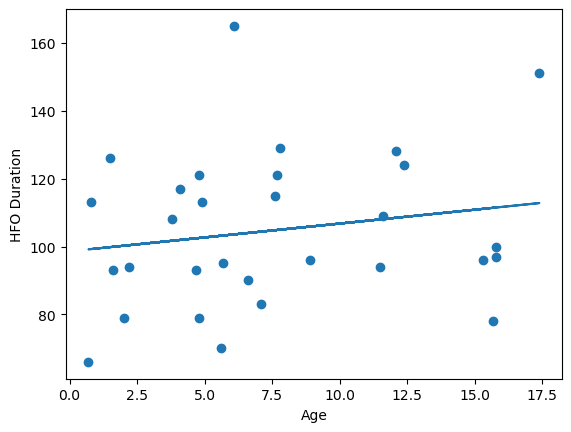

R² = 0.0325


In [35]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))


plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel('Age')
plt.ylabel('HFO Duration')
plt.show()

# r^2

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Calculate R^2
r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")

### without removing outliers using IQR method

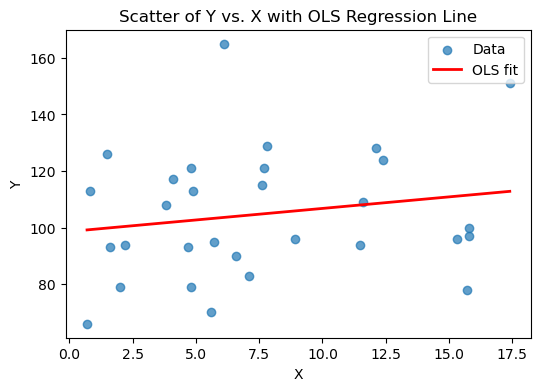

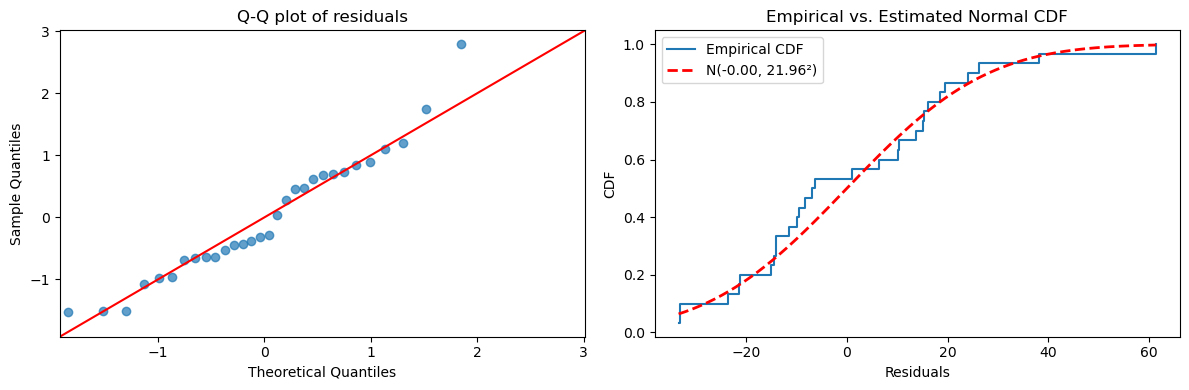

In [61]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 

df = participants

X_sm = sm.add_constant(df['age'])  
#print(df)     # add intercept
model = sm.OLS(df['HFODuration'], X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(df['age'], df['HFODuration'], alpha=0.7, label='Data')
x_vals = np.linspace(df['age'].min(), df['age'].max(), 100)
y_vals = model.params['const'] + model.params['age'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

### with removing outliers using IQR method

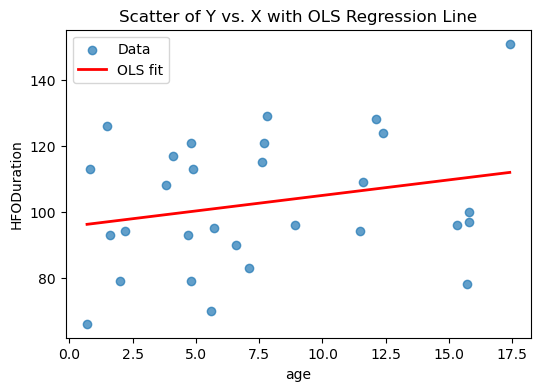

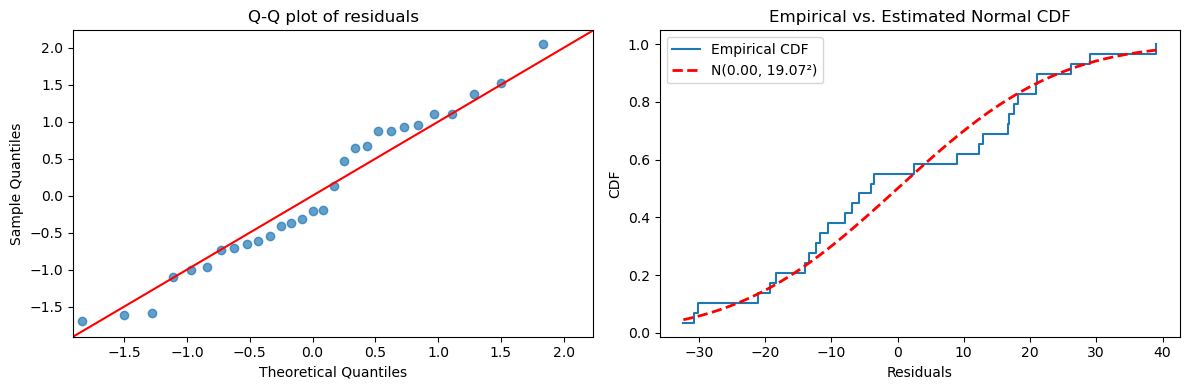

In [79]:
#regression graph of duration vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 

q1, q3 = participants['HFODuration'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

df = participants

X_sm = sm.add_constant(x)  

#print(df)     # add intercept
model = sm.OLS(y, X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7, label='Data')
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = model.params['const'] + model.params['age'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

In [63]:
#bootstrapping confidence interval for slope
x = participants['age'] #independent variable, change this depending on what you're looking at
x = participants['age'].to_numpy()
y = participants['HFODuration'].to_numpy() #dependent variable, change 
x = x.reshape(-1, 1)

df = participants

bootstraps = 1000
boots = []

for _ in range(bootstraps):
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_sample = x[indices]
    y_sample = y[indices]

    model = LinearRegression().fit(x_sample, y_sample)
    boots.append(model.coef_[0])  # Save the slope


slopes = np.array(boots)

lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)

print(f"95% CI for the slope: ({lower:.4f}, {upper:.4f})")

95% CI for the slope: (-0.8269, 2.5065)


# HFO Duration by Age Group

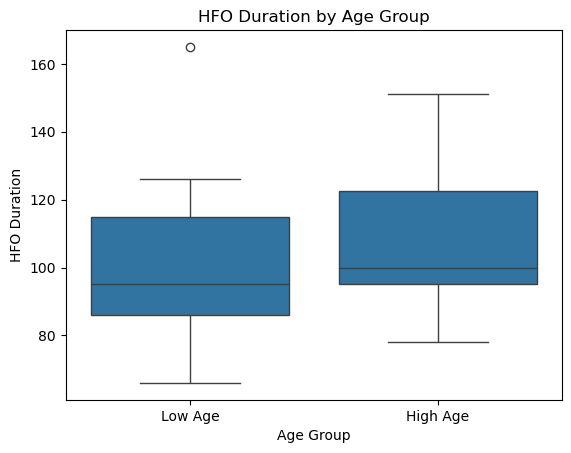

p-value = 0.5349


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your updated participants.csv
participants = pd.read_csv('participants.csv')

# Divide into two groups: low age and high age based on the median
median_age = participants['age'].median()
participants['age_group'] = ['Low Age' if age < median_age else 'High Age' for age in participants['age']]

sns.boxplot(x='age_group', y='HFODuration', data=participants)
plt.title('HFO Duration by Age Group')
plt.xlabel('Age Group')
plt.ylabel('HFO Duration')
plt.show()

low_age = participants[participants['age_group'] == 'Low Age']['HFODuration']
high_age = participants[participants['age_group'] == 'High Age']['HFODuration']

stat, p = ttest_ind(low_age, high_age, equal_var=False)
print(f'p-value = {p:.4f}')

# Duration vs. Sex

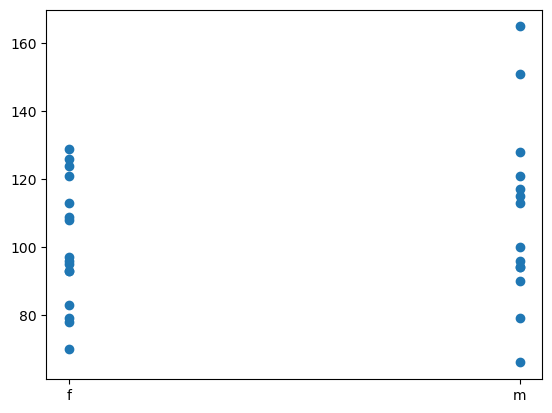

In [7]:
#regression graph of duration vs. sex

import matplotlib.pyplot as plt
from scipy import stats

x = participants['sex']
y = participants['HFODuration']

plt.scatter(x, y)
plt.show()

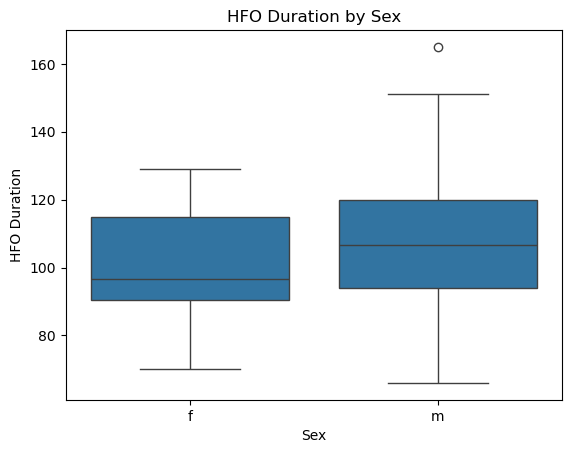

p-value = 0.3378


In [11]:
from scipy.stats import ttest_ind

participants = pd.read_csv('participants.csv')

# Boxplot of HFO Duration by Sex
sns.boxplot(x='sex', y='HFODuration', data=participants)
plt.title('HFO Duration by Sex')
plt.xlabel('Sex')
plt.ylabel('HFO Duration')
plt.show()

# Create two groups: Male and Female
male = participants[participants['sex'] == 'm']['HFODuration']
female = participants[participants['sex'] == 'f']['HFODuration']

# Perform independent t-test
stat, p = ttest_ind(male, female, equal_var=False)
print(f'p-value = {p:.4f}')

# Count vs Age

In [41]:
def hfocount(subjn, runn):
    subjectfile = fr'C:\Users\washi\trying again\derivatives\sub-{subjn}\ses-01\eeg\sub-{subjn}_ses-01_task-hfo_run-0{runn}_events.tsv'
    df = pd.read_csv(subjectfile, sep='\t', header=0)
    return df['nChannel'].count()

nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
hfocounts = []
for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + hfocount(subj, i)
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    hfocounts.append(int(avg))

for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        if (os.path.exists(fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv')):
            try:
                avg = avg + hfocount(subj, i)
                count = count + 1
            except:
                continue
    if (count != 0):
        avg = avg / count
    hfocounts.append(int(avg))

participants = pd.read_csv(r'participants.tsv', sep='\t', header=0)
participants['HFODuration'] = avgdurations #be sure to stack!!
participants['hfocount'] = hfocounts
participants.to_csv('participants.csv', index=False)
participants = pd.read_csv('participants.csv')

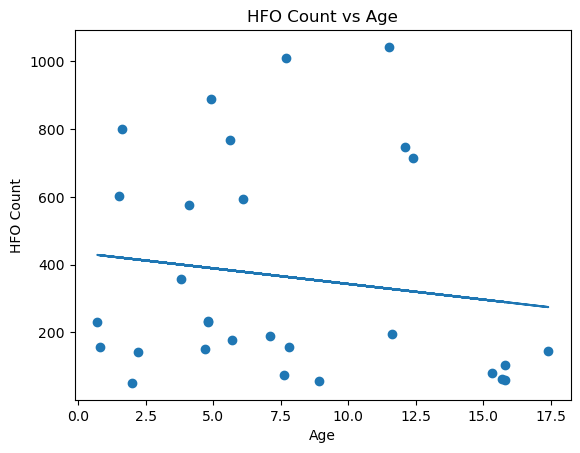

R² = 0.0212


In [40]:
x = participants['age']
y = participants['hfocount']

q1, q3 = participants['hfocount'].quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title('HFO Count vs Age')
plt.xlabel('Age')
plt.ylabel('HFO Count')
plt.show()

# r^2

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Calculate R^2
r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")

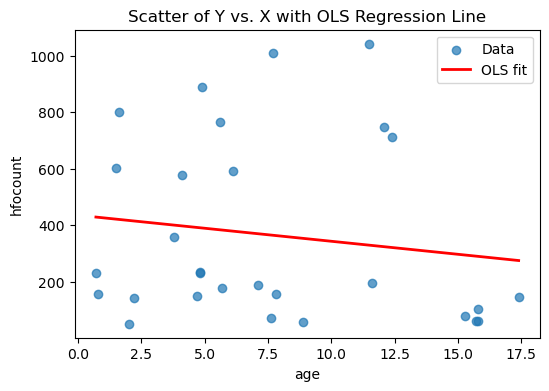

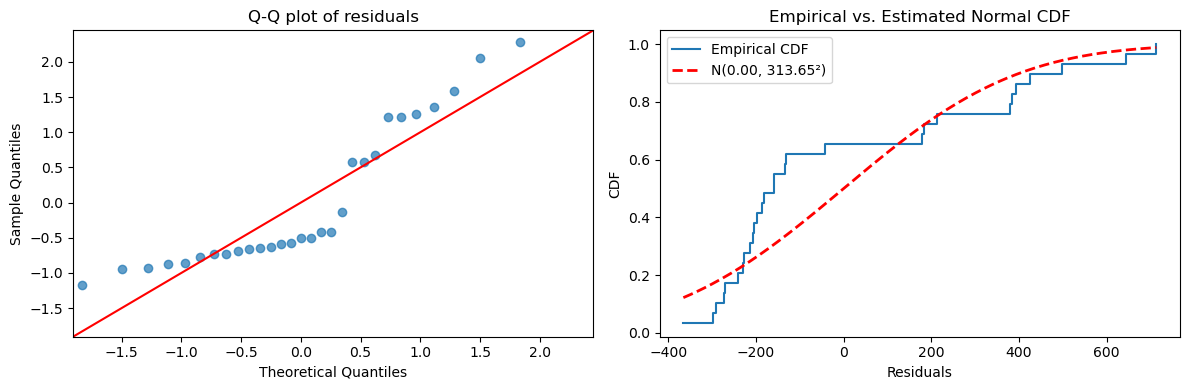

In [80]:
#regression graph of count vs. age
x = participants['age'] #independent variable, change this depending on what you're looking at
y = participants['hfocount'] #dependent variable, change 

x = participants['age']
y = participants['hfocount']


q1, q3 = participants['hfocount'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

df = participants

X_sm = sm.add_constant(x)  
#print(df)     # add intercept
model = sm.OLS(y, X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7, label='Data')
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = model.params['const'] + model.params['age'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

In [86]:
x = participants['age']
y = participants['hfocount']

q1, q3 = y.quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

x = x.to_numpy().reshape(-1, 1)
y = y.to_numpy()
df = participants

bootstraps = 1000
boots = []

for _ in range(bootstraps):
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_sample = x[indices]
    y_sample = y[indices]

    model = LinearRegression().fit(x_sample, y_sample)
    boots.append(model.coef_[0])  # Save the slope


slopes = np.array(boots)

lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)

print(f"95% CI for the slope: ({lower:.4f}, {upper:.4f})")

95% CI for the slope: (-27.6701, 14.0462)


# Event Peak 2 Peaks

In [44]:
avg_peak2peaks = []

for subj in nine:
    avg = 0
    count = 0
    for i in range(1, 19):
        filepath = fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv'
        if os.path.exists(filepath):
            try:
                avg += avg_peak2peak(subj, i)  # assumes you already defined avg_peak2peak
                count += 1
            except:
                continue
    if count != 0:
        avg /= count
    avg_peak2peaks.append(int(avg))

for subj in range(10, 31):
    avg = 0
    count = 0
    for i in range(1, 19):
        filepath = fr'C:\Users\washi\trying again\derivatives\sub-{subj}\ses-01\eeg\sub-{subj}_ses-01_task-hfo_run-0{i}_events.tsv'
        if os.path.exists(filepath):
            try:
                avg += avg_peak2peak(subj, i)
                count += 1
            except:
                continue
    if count != 0:
        avg /= count
    avg_peak2peaks.append(int(avg))

participants = pd.read_csv(r'participants.tsv', sep='\t', header=0)
participants['HFODuration'] = avgdurations
participants['hfocount'] = hfocounts
participants['AvgEventPeak2Peak'] = avg_peak2peaks
participants.to_csv('participants.csv', index=False)

## HFO Count VS Event Peak 2 Peaks

with filtering out outliers using IQR method

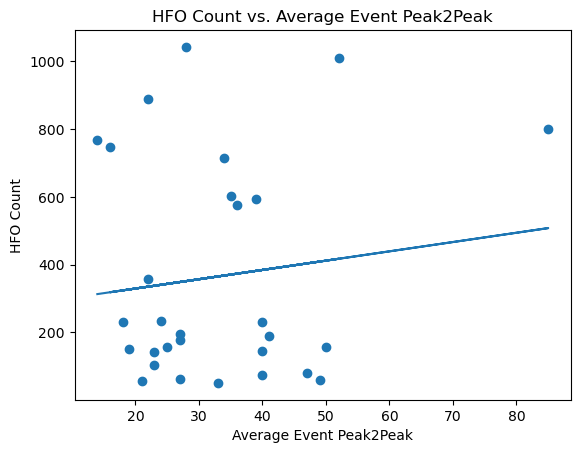

R² = 0.0155
Correlation coefficient r = 0.1246, p = 0.5197


In [68]:
x = participants['AvgEventPeak2Peak']
y = participants['hfocount']

q1, q3 = participants['hfocount'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

slope, intercept, r, p, stderr = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

# Scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel('Average Event Peak2Peak')
plt.ylabel('HFO Count')
plt.title('HFO Count vs. Average Event Peak2Peak')
plt.show()

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")
print(f"Correlation coefficient r = {r:.4f}, p = {p:.4g}")

without filtering out outliers??

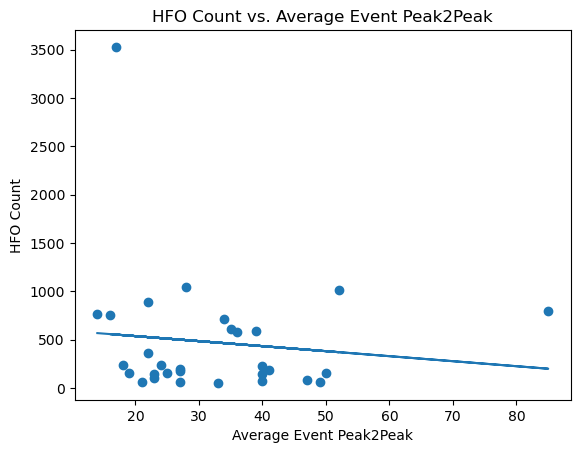

R² = 0.0134
Correlation coefficient r = -0.1157, p = 0.5426


In [69]:
x = participants['AvgEventPeak2Peak']
y = participants['hfocount']

slope, intercept, r, p, stderr = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

# Scatter plot
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel('Average Event Peak2Peak')
plt.ylabel('HFO Count')
plt.title('HFO Count vs. Average Event Peak2Peak')
plt.show()

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")
print(f"Correlation coefficient r = {r:.4f}, p = {p:.4g}")

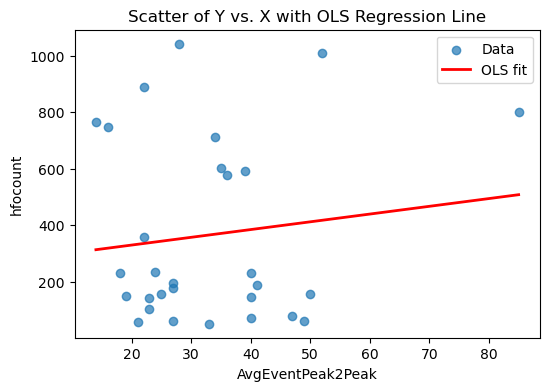

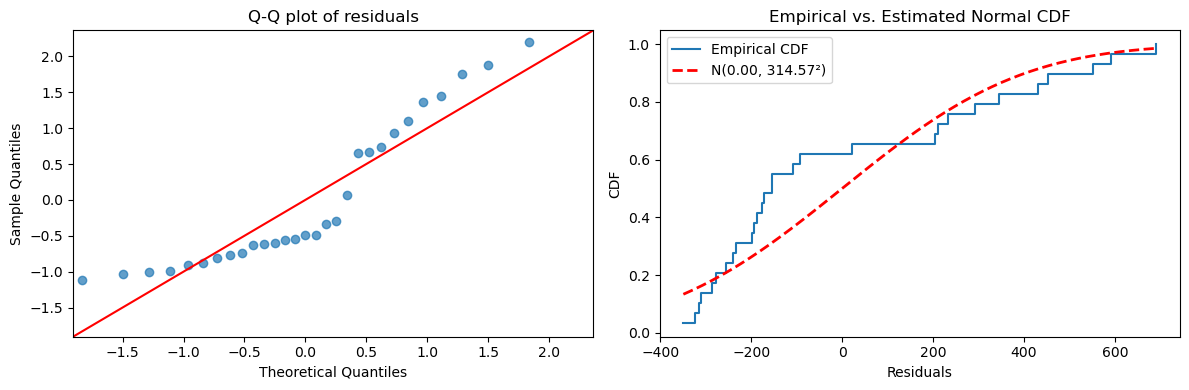

In [77]:
x = participants['AvgEventPeak2Peak']
y = participants['hfocount']

q1, q3 = participants['hfocount'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

df = participants

X_sm = sm.add_constant(x)  
#print(df)     # add intercept
model = sm.OLS(y, X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7, label='Data')
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = model.params['const'] + model.params['AvgEventPeak2Peak'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

### bootstrap

In [84]:
x = participants['AvgEventPeak2Peak']
y = participants['hfocount']

q1, q3 = y.quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

x = x.to_numpy().reshape(-1, 1)
y = y.to_numpy()
df = participants

bootstraps = 1000
boots = []

for _ in range(bootstraps):
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_sample = x[indices]
    y_sample = y[indices]

    model = LinearRegression().fit(x_sample, y_sample)
    boots.append(model.coef_[0])  # Save the slope


slopes = np.array(boots)

lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)

print(f"95% CI for the slope: ({lower:.4f}, {upper:.4f})")

95% CI for the slope: (-11.9809, 9.1675)


# HFO Count VS HFO Duration

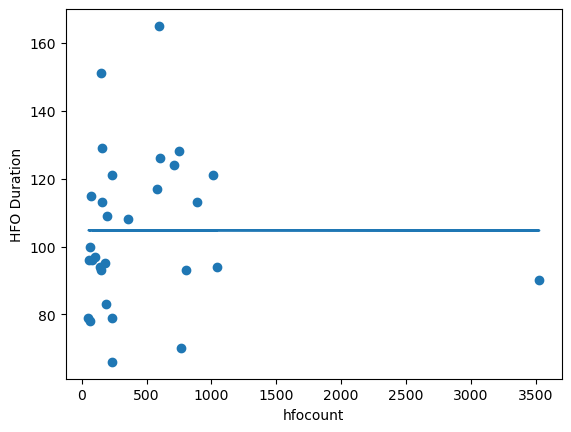

R² = 0.0000


In [ ]:
x = participants['hfocount'] #independent variable, change this depending on what you're looking at
y = participants['HFODuration'] #dependent variable, change 


slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel('hfocount')
plt.ylabel('HFO Duration')
plt.show()

# r^2

x = np.array([float(num) for num in x]).reshape(-1, 1)
y = [float(num) for num in y]

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Calculate R^2
r_squared = r2_score(y, y_pred)
print(f"R² = {r_squared:.4f}")

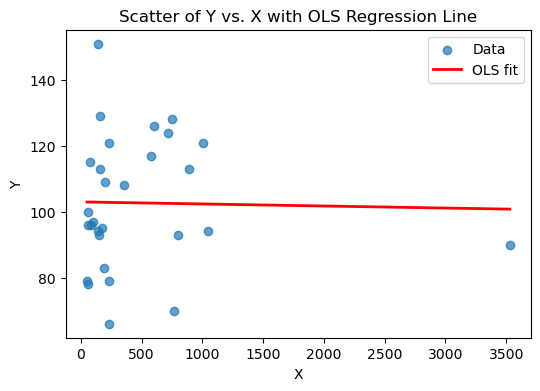

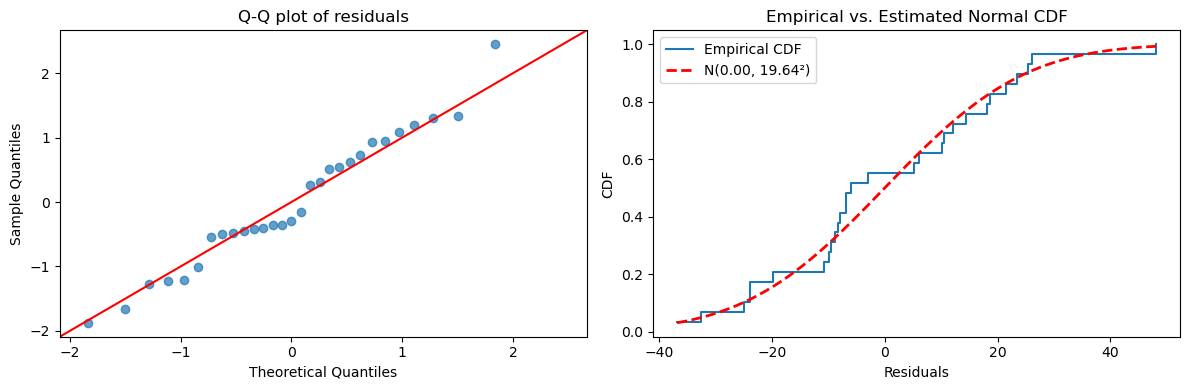

In [74]:
x = participants['hfocount']
y = participants['HFODuration']


q1, q3 = participants['HFODuration'].quantile([0.25,0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr

mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

df = participants

X_sm = sm.add_constant(x)  
#print(df)     # add intercept
model = sm.OLS(y, X_sm).fit()
plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7, label='Data')
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = model.params['const'] + model.params['hfocount'] * x_vals
plt.plot(x_vals, y_vals, color='red', lw=2, label='OLS fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter of Y vs. X with OLS Regression Line')
plt.legend()
plt.show()

# Extract residuals
resid = model.resid
n = len(resid)
sorted_resid = np.sort(resid)
ecdf = np.arange(1, n+1) / n

# MLE estimates for residual distribution
mu_hat = resid.mean()
sigma_hat = np.sqrt(((resid - mu_hat)**2).sum() / n)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Q‑Q plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0], alpha=0.7)
axes[0].set_title('Q‑Q plot of residuals')

# ECDF + theoretical CDF
axes[1].step(sorted_resid, ecdf, where='post', label='Empirical CDF')
x_vals = np.linspace(sorted_resid.min(), sorted_resid.max(), 200)
axes[1].plot(x_vals, norm.cdf(x_vals, loc=mu_hat, scale=sigma_hat),
             'r--', lw=2, label=f'N({mu_hat:.2f}, {sigma_hat:.2f}²)')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('CDF')
axes[1].set_title('Empirical vs. Estimated Normal CDF')
axes[1].legend()

plt.tight_layout()
plt.show()

In [85]:
x = participants['hfocount']
y = participants['HFODuration']

q1, q3 = y.quantile([0.25, 0.75])
iqr = q3 - q1
lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
mask = (y >= lo) & (y <= hi)

x = x[mask]
y = y[mask]

x = x.to_numpy().reshape(-1, 1)
y = y.to_numpy()
df = participants

bootstraps = 1000
boots = []

for _ in range(bootstraps):
    indices = np.random.choice(len(x), size=len(x), replace=True)
    x_sample = x[indices]
    y_sample = y[indices]

    model = LinearRegression().fit(x_sample, y_sample)
    boots.append(model.coef_[0])  # Save the slope


slopes = np.array(boots)

lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)

print(f"95% CI for the slope: ({lower:.4f}, {upper:.4f})")

95% CI for the slope: (-0.0062, 0.0289)
